In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
import joblib as jb
import numpy as np


In [3]:
df = pd.read_csv('../../data/social_media.csv')

In [4]:
df = df[df['platform'] == 'Instagram']
df.drop(columns=['platform'] , inplace=True)

In [5]:
df['ER'] = (df['comments_count'] + df['likes'] + df['shares']+ df['views']) / df['follower_count']

In [6]:
df.drop(df[df['ER'] > 1].index , inplace=True)


In [7]:
mean = df['ER'].mean()
std = df['ER'].std()
high_limit = mean + 3 * std
low_limit = mean - 3 * std
high_limit , low_limit

df = df[df['ER'] <= high_limit]

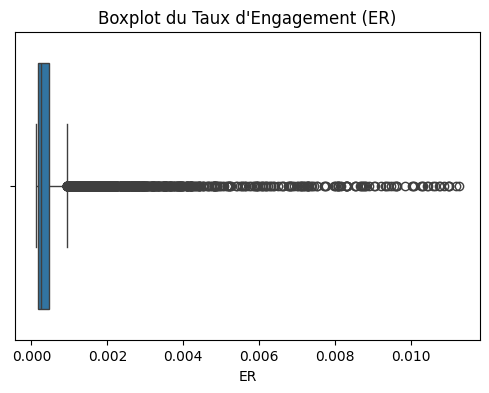

In [8]:
df['ER'].describe()
plt.figure(figsize=(6,4))
sns.boxplot(x=df['ER']/100)
plt.title('Boxplot du Taux d\'Engagement (ER)')
plt.savefig('../../data/boxplot_ER_reparition_v2.png' ,  dpi=300, bbox_inches='tight')
plt.show()

In [9]:
df['day'] = pd.to_datetime(df['post_date']).dt.day_name()
df['hour'] = pd.to_datetime(df['post_date']).dt.hour

/tmp/ipykernel_14545/837538443.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['day'] = pd.to_datetime(df['post_date']).dt.day_name()
/tmp/ipykernel_14545/837538443.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['post_date']).dt.hour


In [13]:
def description_performance_score(description: str) -> float:
    if not description:
        return 0.0
    text = description.lower()
    words = text.split()
    word_count = len(words)
    sentiment = TextBlob(text).sentiment.polarity
    length_score = min(word_count / 30, 1.0)
    cta_words = ["like", "comment", "share", "follow", "dis", "pense"]
    cta_count = sum(word in words for word in cta_words)
    cta_score = min(cta_count / 2, 1.0)
    avg_word_length = sum(len(w) for w in words) / max(word_count, 1)
    readability_score = 1 - min(avg_word_length / 10, 1)
    return round(
        0.3 * sentiment +
        0.25 * length_score +
        0.25 * cta_score +
        0.2 * readability_score,
        3
    )


In [14]:
import re

def extract_hashtags(hashtags: str) -> list[str]:

    if pd.isna(hashtags) or not isinstance(hashtags, str):
        return []

    return [
        tag.strip().lower()
        for tag in hashtags.split(",")
        if tag.strip()
    ]


def count_hashtags(hashtags: str) -> int:
    return len(extract_hashtags(hashtags))


def hashtag_quantity_score(n: int) -> float:
    if n == 0:
        return 0.0
    if 5 <= n <= 15:
        return 1.0
    if n < 5:
        return n / 5
    return max(0.0, 1 - (n - 15) / 15)


def hashtag_relevance_score(description: str, hashtags: str) -> float:
    if not description or not hashtags:
        return 0.0

    desc_words = set(
        re.findall(r"\b\w+\b", description.lower())
    )

    tag_words = set(extract_hashtags(hashtags))

    if not tag_words:
        return 0.0

    common = desc_words.intersection(tag_words)
    return len(common) / len(tag_words)

def hashtag_diversity_score(hashtags: str) -> float:
    tags = extract_hashtags(hashtags)
    if not tags:
        return 0.0

    avg_len = sum(len(tag) for tag in tags) / len(tags)
    return min(avg_len / 15, 1.0)


def hashtag_specificity_score(hashtags: str) -> float:
    tags = extract_hashtags(hashtags)
    if not tags:
        return 0.0

    long_tags = [t for t in tags if len(t) >= 8]
    return len(long_tags) / len(tags)


def hashtag_quality_score(description: str, hashtags: str) -> float:
    """
    Score final [0,1] mesurant la qualité globale des hashtags
    """
    tags = extract_hashtags(hashtags)
    n = len(tags)

    score = (
        0.30 * hashtag_quantity_score(n)
      + 0.30 * hashtag_relevance_score(description, hashtags)
      + 0.20 * hashtag_diversity_score(hashtags)
      + 0.20 * hashtag_specificity_score(hashtags)
    )

    return round(score, 3)

def extract_hashtag_features(row):
    return pd.Series({
        'hashtag_count': count_hashtags(row['hashtags']),
        'hashtag_quality_score': hashtag_quality_score(
            row['content_description'],
            row['hashtags']
        )
    })


In [15]:
df['description_score'] = df['content_description'].apply(description_performance_score)
df[['hashtag_count', 'hashtag_quality_score']] = df.apply(
    extract_hashtag_features,
    axis=1
)

In [16]:
day_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

df['day_num'] = df['day'].map(day_map)
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)


In [17]:
df = pd.get_dummies(df, columns=['content_type'], drop_first=True)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [18]:
df.columns

Index(['post_date', 'content_length', 'content_description', 'hashtags',
       'views', 'likes', 'shares', 'comments_count', 'follower_count', 'ER',
       'day', 'hour', 'description_score', 'hashtag_count',
       'hashtag_quality_score', 'day_num', 'day_sin', 'day_cos',
       'content_type_mixed', 'content_type_text', 'content_type_video'],
      dtype='object')

In [19]:
df.drop(columns=['post_date' , 'content_description' , 'likes' ,'views','shares' ,'hashtags','day_num' ,'day' , 'comments_count'] , inplace=True)

In [20]:
df.dropna(inplace=True)
print("Rows with NaN values have been dropped.")

Rows with NaN values have been dropped.


In [23]:
df.to_csv('../../data/final_v3.csv' , index=False)